<a href="https://colab.research.google.com/github/arigqt/SampleProjects/blob/main/ComputerVision_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of the CIFAR-10 dataset 🚀🚀🚀

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.  The figure below provides a random sample of some images in each category.

![images.png](images.png)

During this session, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories.  We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow. Begin by importing the necessary modules.

In [ ]:
import os
import time
import datetime
from tqdm import tqdm_notebook

import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.metrics import CategoricalAccuracy
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras import layers
from tensorflow import keras
from keras.callbacks import EarlyStopping

import random

random.seed(1999)


# Table of content

[1. A first look at the data set](#dataset)<br>

[2. A first naive model](#first_model)<br>

[3. Convolutional Neural Networks](#cnn)<br>
- [3.1 Create your first CNN](#first_cnn)<br>
- [3.2 Influence of parameters on the performance](#cnn_parameters)<br>
- [3.3 Studying predictions](#results)<br>

[4. Pretrained Networks](#pretrained_cnn)<br>


<a id='dataset'></a>
# 1 - A first look at the data set

**1) Download the dataset. See [`keras.datasets`](https://keras.io/datasets/) for how to download the data.  Note that the dataset is already divided into a training set of 50000 images, and a test set of 10000.**

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


170498071/170498071 [==============================] - 2s 0us/step


**2) Check the shape of images and targets.**

In [ ]:
print(f"TRAIN - Shape of the image : {X_train.shape}")
print(f"TRAIN - Shape of the target : {y_train.shape}")

print(f"TEST - Shape of the image : {X_test.shape}")
print(f"TEST - Shape of the target : {y_test.shape}")


TRAIN - Shape of the image : (50000, 32, 32, 3)
TRAIN - Shape of the target : (50000, 1)
TEST - Shape of the image : (10000, 32, 32, 3)
TEST - Shape of the target : (10000, 1)


 **3) Create a list of labels corresponding to the 10 categories.  This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows**  
  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck


In [ ]:
categories = ["airplane",
              "automobile",
              "bird",
              "cat",
              "deer",
              "dog",
              "frog",
              "horse",
              "ship",
              "truck"]

**4) Normalize images from [0,255] to be [0,1] (normalizing usually improves model training).**

In [ ]:
X_train = X_train/255
X_test = X_test/255


**5) Convert the target arrays to one-hot encodings.  Hint: checkout the [`keras.utils.to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)**

In [ ]:
encoded_target = to_categorical(y_train, 10)
encoded_target_test = to_categorical(y_test, 10)
encoded_target


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

**6) Visualize some images in each category using the `imshow()` function in `matplotlib.pyplot`.  Can you recreate the figure at the top?  Hint: the top figure was created using the first 8 images belonging to each category in the training data.**

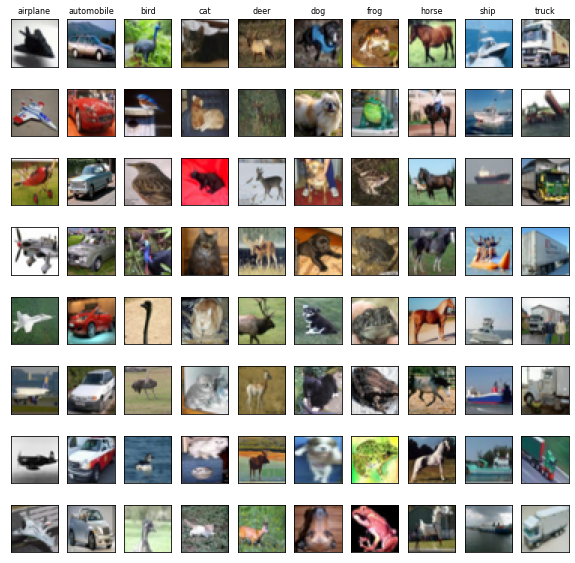

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=10, figsize=(10,10))

for j in range(10):
    index = np.where(y_train==j)[0][:8]
    row = 0
    for i in index:
        axes[row, j].imshow(X_train[i])
        axes[row, j].get_xaxis().set_visible(False)
        axes[row, j].get_yaxis().set_visible(False)
        row +=1
    axes[0, j].set_title(categories[j], fontsize=8)

In [ ]:
#The following code summarizes all previous operations. 
#No Need to fill in this cell. You can continue the lab.


#
#
# YOUR CODE HERE
#
#


<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

#### Initilization
**7) Create a sequential model with 4 `Dense` hidden layers of 1024, 512, 256, and 100 nodes each, with ReLU activation, and an output layer suited for the learning task. For the training, use the SGD optimizer with a learning rate of 0.1 and a decay of $10^{-6}$. The performance of the network will be assessed via the accuracy metric.**

In [ ]:
# In order to build a "naive" model with no convolution I need to reshape
# the input data from 4D to 2D by flattening the last two dimensions
X_train_reshape = X_train.reshape(X_train.shape[0], 32*32*3)

X_test_reshape = X_test.reshape(X_test.shape[0], 32*32*3)

In [ ]:
model_naive = Sequential([
    Dense(1024, input_shape= (3072,), activation='relu', name='layer1'),
    Dense(512, activation='relu', name='layer2'),
    Dense(256, activation='relu', name='layer3'),
    Dense(100, activation='relu', name='layer4'),
    Dense(10, activation='softmax', name='output')
])

opt = SGD(learning_rate=0.1, decay = 10e-6)
model_naive.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 

#### Parameters
**8) Compute by hand the total number of trainable parameters (weights and biases) in the model.**

Layer by layer number of parameters (for the weight and biaises) : <br>
$n_{input}*n_{output} + n_{output}$ trainable parameters.

- 1st layer : input shape (3072,) & output shape (1024) $3\ 072 * 1\ 024 + 1024 = 3\ 146\ 752$ trainable parameters
- 2nd layer : input shape (1024,) & output shape (512),  $1024 * 512 + 512 = 524\ 800$ trainable parameters
- 3rd dense layer :  input shape (512,) & output shape (256),  $512 * 256 + 256 = 131\ 328$ trainable parameters
- 4th dense layer :  input shape (256,) & output shape (100),  $256 * 100 + 100 = 25\ 700$ trainable parameters
- The final output dense layer has input shape (100,) and output shape (10),  $100 * 10 + 10 = 1\ 010$ trainable parameters

Total number of trainable parameters :
$$3\ 146\ 752 + 524\ 800 + 131\ 328 + 25\ 700 + 1\ 010 = 3\ 829\ 590$$


**9) Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [ ]:
model_naive.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 1024)              3146752   
                                                                 
 layer2 (Dense)              (None, 512)               524800    
                                                                 
 layer3 (Dense)              (None, 256)               131328    
                                                                 
 layer4 (Dense)              (None, 100)               25700     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 3,829,590
Trainable params: 3,829,590
Non-trainable params: 0
_________________________________________________________________


We find the same number of parameters : 3 929 590.

#### Train, fit and predictions
**10) Train the model for 10 epochs, with a batch size of 32 (you may also use early stopping). What is the model performance?**

In [ ]:
history_naive = model_naive.fit(X_train_reshape, encoded_target, epochs = 10, batch_size=32)

Epoch 1/10
1563/1563 [==============================] - 9s 3ms/step - loss: 1.9137 - accuracy: 0.3037
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.7054 - accuracy: 0.3864
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.6167 - accuracy: 0.4182
Epoch 4/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.5511 - accuracy: 0.4436
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.5011 - accuracy: 0.4611
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.4507 - accuracy: 0.4826
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.4109 - accuracy: 0.4940
Epoch 8/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3709 - accuracy: 0.5078
Epoch 9/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3317 - accuracy: 0.5226
Epoch 10/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.294

After training our model for 10 epochs and with a batch size of 32 we obtain an accuracy of approximately 0.54, meaning a bit more than 1 out of two images is correctly categorized with our current model.

**11) Plot several images with their predictions. Any comment?**

In [ ]:
# Predict the category for each image in X_test :
prediction_naive = model_naive.predict(X_test_reshape, batch_size=32)

# We get for each test image input an Array 1x10 with the probabilities that 
# the image belongs to the category i

# Extract the category from the index of the max probability 
categ_predicted = [np.argmax(prediction_naive[i]) for i in range(len(prediction_naive))]
categ_predicted[:15]

313/313 [==============================] - 1s 2ms/step


[3, 9, 1, 0, 4, 6, 3, 6, 3, 1, 0, 9, 3, 7, 9]

In [ ]:
perf = [categ_predicted[i]==y_test[i] for i in range(len(y_test))]
accuracy = np.sum(perf)/ len(perf)
print(f"True predictions on the whole test data set = {accuracy*100} %")

True predictions on the whole test data set = 50.239999999999995 %


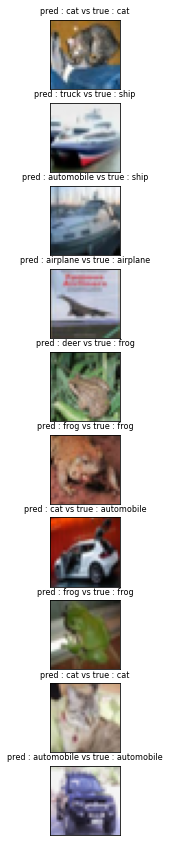

In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(15,15))

for i in range(10):
    axes[i].imshow(X_test[i])
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].set_title(f"pred : {categories[categ_predicted[i]]} vs true : {categories[y_test[i][0]]}", fontsize=8)


The prediction is not good and inaccurate one time out of two.

<a id='cnn'></a>

# 3 - Convolutional Neural Network
 

Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general).  In this task, you will build your first convolutional network and see how it performs during training.

<a id='first_cnn'></a>
## 3.1 - Create your first CNN

#### Initilization
**12) Create a new model with the following layers (use the same optimizer and loss as above)**
  - 3x3 2D convolution with zero-padding, a stride of 1, 8 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, a stride of 1, 8 filters
  - ReLU activation
  - Max pooling with size (2,2) and a stride of 2
  - 3x3 2D convolution, with zero-padding, a stride of 1, 32 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, a stride of 1, 32 filters
  - ReLU activation
  - Max pooling with size (2,2) and a stride of 2
  - Flatten
  - Dense layer with 408 nodes, ReLU activation
  - A well-chosen output layer

In [ ]:
model_CNN = Sequential() # our defined model functions in some sort of sequence, we use the Sequential class to initialize our model before adding the layers

# Conv1 
model_CNN.add(Conv2D(filters=8, 
                     kernel_size=(3, 3), 
                     strides=1, 
                     padding='valid', 
                     activation='relu', 
                     input_shape=X_train.shape[1:]
                     ))
# Conv2 
model_CNN.add(Conv2D(filters=8, 
                     kernel_size=(3, 3), 
                     strides=1, 
                     padding='valid', 
                     activation='relu'
                     ))
# Pool1 
model_CNN.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=2
                           )) 
# Conv3
model_CNN.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     strides=1, 
                     padding='valid', 
                     activation='relu'
                     ))
# Conv4 
model_CNN.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     strides=1, 
                     padding='valid', 
                     activation='relu'
                     ))

# Pool2 
model_CNN.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=2
                           )) 

# FC layers 
model_CNN.add(Flatten()) # to turn input into a 1 dimensional array

# Dense1 
model_CNN.add(Dense(408, activation='relu'))

# Output layer
model_CNN.add(Dense(10, activation='softmax'))


#### Parameters
**13) Compute by hand the number of trainable parameters in this network.  Are there more or less than the more simple dense network?  Why?  Confirm with `summary()`.**

- **Conv 1** : 8 filters with kernel size (3,3), with the input size of 3,  $8 \times (3\times 3 )\times 3 + 8 8 \times (27 + 1) =$ **224** trainable parameters
- **Conv 2** : 8 filters with kernel size (3,3) for an input of the previous 8 filters,  $ 8 \times (3 \times 3) \times 8 + 8 =$ **584** trainable parameters
- **Pooling**: no additional trainable parameters, the input dimension is reduced by a factor 2 from 64 to $\sqrt 64 = 8$
- **Conv3**: 32 filters with kernel size (3,3), with the input size of 8,  $32 \times (3 \times 3) \times 8 + 8 =$ **2 336** trainable parameters
-**Conv4** : 32 filters with kernel size (3,3), with the input size of 32,  $32 * (3 \times 3) \times 32 + 32 =$ **9 248** trainable parameters

- **Pooling & Flatten**: no additional trainable parameters, the input dimension is reduced by a factor 2 (with pooling) and increases with the flattening from 64 to $\sqrt 32 \times 32 = 8$

- **Dense layer 1**: input shape $32 \times 5 \times 5= 800 $ and 408 nodes,  $800 \times 408 + 408 =$ **326 808** trainable parameters
- **Dense layer 1**: input shape 408 and 10 nodes,  $408 \times 10 + 10 =$ **4 090** trainable parameters

Total number of trainable parameters in the CNN model is :
$224 +584 + 2\ 336 + 9\ 248 + 326\ 808 + 4\ 090= $ **343 290** <br>

There are less number of parameters in this CNN model than the previous dense network (3,829,590), because with convolutional layers we don't need to cover all possible patterns in the images, due to the sharing of weights in the spatial dimensions, which makes the model more compact, less prone to overfitting and more efficient computationally.

In [ ]:
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        2336      
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                  

Once again, we find the same number of parameters : 343 290.

#### Train, fit and predictions
**14) Train the network for 10 epochs, with batch size of 32. How does the validation accuracy change with each epoch?**

In [ ]:
# Compile the model
opt = SGD(learning_rate=0.1, decay = 10e-6)
model_CNN.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'], 
                  )


In [ ]:
history_CNN = model_CNN.fit(X_train, encoded_target, 
                        epochs =10, 
                        batch_size=32, 
                        validation_data=(X_test,  encoded_target_test)
)

Epoch 1/10
1563/1563 [==============================] - 13s 5ms/step - loss: 1.9271 - accuracy: 0.2859 - val_loss: 1.6019 - val_accuracy: 0.4232
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4146 - accuracy: 0.4892 - val_loss: 1.5970 - val_accuracy: 0.4339
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2306 - accuracy: 0.5618 - val_loss: 1.2355 - val_accuracy: 0.5632
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0949 - accuracy: 0.6139 - val_loss: 1.1978 - val_accuracy: 0.5797
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9785 - accuracy: 0.6567 - val_loss: 1.1680 - val_accuracy: 0.6055
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8825 - accuracy: 0.6882 - val_loss: 1.2642 - val_accuracy: 0.5798
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7925 - accuracy: 0.7222 - val_loss: 1.2294 - val_accuracy

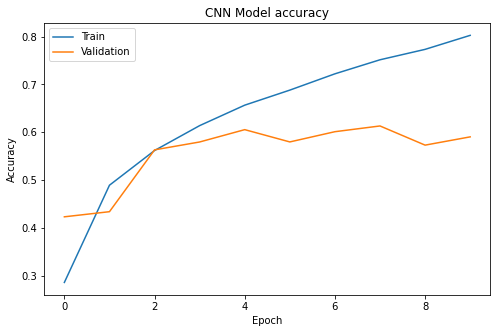

313/313 - 1s - loss: 1.6322 - accuracy: 0.5904 - 1s/epoch - 4ms/step


In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 5))
plt.plot(history_CNN.history['accuracy'])
plt.plot(history_CNN.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

test_loss, test_acc = model_CNN.evaluate(X_test, encoded_target_test, verbose=2)

The model accuracy is **better** with a CNN and the validation accuracy generally improves through the epochs, even though it reaches its maximum at 9 epochs. We could make an early stopping at 9 epochs. The decreasing is due to overfitting.

 
<a id='cnn_parameters'></a>
## 3.2 - Influence of parameters on the performance

#### Batch size
**15) How does the performance depend on batch size?**

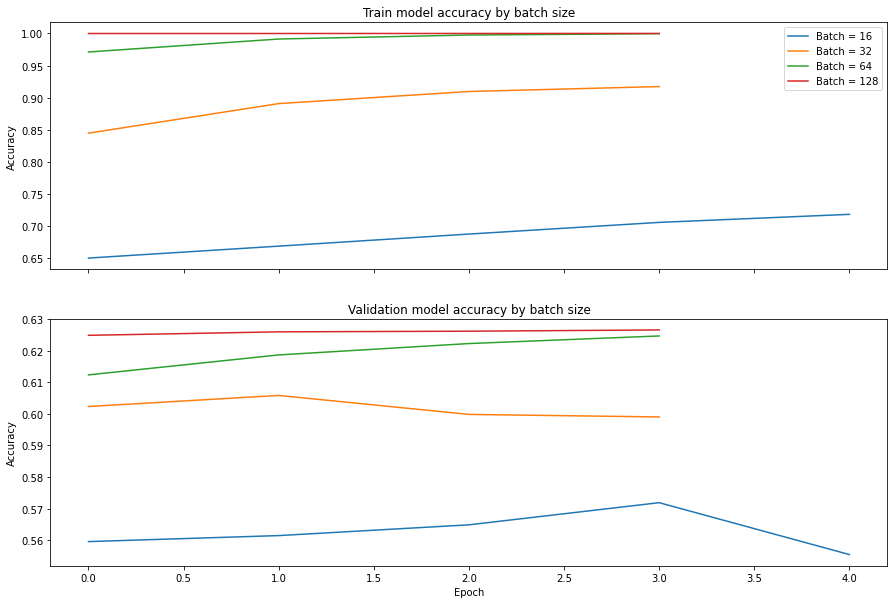

In [ ]:
# Plot the evolution of (train/val) accuracy through epoch
batch_sizes = [16, 32, 64, 128]
fig, ax = plt.subplots(2, figsize=(15, 10), sharex=True)

for batch_size in batch_sizes:
    batch = model_CNN.fit(X_train, 
                          encoded_target, 
                          epochs=10, 
                          batch_size=batch_size, 
                          validation_data=(X_test, encoded_target_test),
                          callbacks=EarlyStopping(monitor='val_loss', patience=3),
                          verbose=False
                          )

    ax[0].plot(batch.history['accuracy'], label=f'Batch = {batch_size}')
    ax[0].set_title('Train model accuracy by batch size')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='upper right');

    ax[1].plot(batch.history['val_accuracy'], label=f'Batch = {batch_size}')
    ax[1].set_title('Validation model accuracy by batch size')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')

The validation accuracy improves with the number of batch size. However, batch 64 and 128 tend to reach a maximum at 3 epochs.

**16) Consider now a batch size of 32 and consider the above CNN. Try adding 3 dropout layers to this model, one after each max-pooling layer and one before the last layer, using a dropout of parameter p=0.25. Does this improve the model? How does the performance vary with the dropout ratio? What does p correspond to?**

In [ ]:
model_CNN_dropout = Sequential() # our defined model functions in some sort of sequence, we use the Sequential class to initialize our model before adding the layers

# Conv1 
model_CNN_dropout.add(Conv2D(filters=8, 
                     kernel_size=(3, 3), 
                     strides=1, 
                     padding='valid', 
                     activation='relu', 
                     input_shape=X_train.shape[1:]
                     ))
# Conv2 
model_CNN_dropout.add(Conv2D(filters=8, 
                     kernel_size=(3, 3), 
                     strides=1, 
                     padding='valid', 
                     activation='relu'
                     ))
# Pool1 
model_CNN_dropout.add(MaxPooling2D(pool_size=(2, 2), strides=2))

# Dropout1
model_CNN_dropout.add(Dropout(rate = 0.25))

# Conv3
model_CNN_dropout.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     strides=1, 
                     padding='valid', 
                     activation='relu'
                     ))
# Conv4 
model_CNN_dropout.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     strides=1, 
                     padding='valid', 
                     activation='relu'
                     ))
# Pool2 
model_CNN_dropout.add(MaxPooling2D(pool_size=(2, 2), strides=2)) 

# Dropout2
model_CNN_dropout.add(Dropout(rate = 0.25))

# FC layers 
model_CNN_dropout.add(Flatten()) # to turn input into a 1 dimensional array

# Dense1 
model_CNN_dropout.add(Dense(408, activation='relu'))

# Dropout3
model_CNN_dropout.add(Dropout(rate = 0.25))

# Output layer
model_CNN_dropout.add(Dense(10, activation='softmax'))

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.9476 - accuracy: 0.2830 - val_loss: 1.6788 - val_accuracy: 0.3902
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5778 - accuracy: 0.4247 - val_loss: 1.4741 - val_accuracy: 0.4771
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4452 - accuracy: 0.4762 - val_loss: 1.4409 - val_accuracy: 0.4705
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3682 - accuracy: 0.5070 - val_loss: 1.5842 - val_accuracy: 0.4606
Epoch 5/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.3151 - accuracy: 0.5287 - val_loss: 1.3047 - val_accuracy: 0.5380
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2618 - accuracy: 0.5514 - val_loss: 1.2561 - val_accuracy: 0.5449
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2167 - accuracy: 0.5667 - val_loss: 1.1365 - val_accuracy:

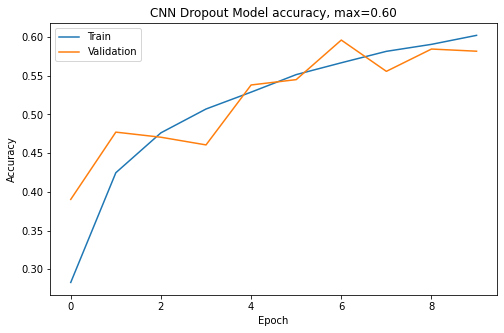

313/313 - 1s - loss: 1.1802 - accuracy: 0.5816 - 763ms/epoch - 2ms/step


In [ ]:
model_CNN_dropout.compile(loss='categorical_crossentropy',
                          optimizer=opt,
                          metrics=['accuracy'])

# Plot the evolution of (train/val) accuracy through epochs
history_dropout = model_CNN_dropout.fit(X_train, 
                                encoded_target, 
                                epochs=10, 
                                batch_size=32, 
                                validation_data=(X_test, encoded_target_test)
                                )

# Plot training & validation accuracy values
max_acc = max(history_dropout.history['accuracy'])
plt.figure(figsize=(8, 5))
plt.plot(history_dropout.history['accuracy'])
plt.plot(history_dropout.history['val_accuracy'])
plt.title(f'CNN Dropout Model accuracy, max={max_acc:.2f}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

test_loss, test_acc = model_CNN_dropout.evaluate(X_test, encoded_target_test, verbose=2)

Here we cann see that adding dropout layers has improved the model, increasing the accuracy to 64% (vs 61% without). Furthermore, the maximum accuracy is reached at the 10th epoch (vs 9th without). <br>

Adding dropout layers to a model can help to improve its performance by **reducing overfitting**. It randomly drops out a certain percentage of the neurons during training, so that the model is forced to learn more robust features that are not dependent on any specific neuron.  <br>

The parameter **p** corresponds to the dropout rate ie the number of neurons we discard in the dropout layer. <br>

The performance will vary depending on the dropout ratio. If the dropout ratio is high, the model's performance may decrease as more neurons are dropped out during training (underfit). On the other hand, if the dropout ratio is low, the model's performance may increase as fewer neurons are dropped out during training but the risk of overfitting, will increase.



#### Batch normalization
**17) Add batch normalization layers before each dropout layer, with the dropout parameter of your choice. What is the impact of batch normalization on the model's performance?**

In [ ]:
model_CNN_dropnorm = Sequential() # our defined model functions in some sort of sequence, we use the Sequential class to initialize our model before adding the layers

# Conv1 
model_CNN_dropnorm.add(Conv2D(filters=8, 
                     kernel_size=(3, 3), 
                     strides=1, 
                     padding='valid', 
                     activation='relu', 
                     input_shape=X_train.shape[1:]))
# Conv2 
model_CNN_dropnorm.add(Conv2D(filters=8, 
                     kernel_size=(3, 3), 
                     strides=1, 
                     padding='valid', 
                     activation='relu'))
# Pool1 
model_CNN_dropnorm.add(MaxPooling2D(pool_size=(2, 2), strides=2)) 
# Batch 1
model_CNN_dropnorm.add(BatchNormalization())
# Dropout1
model_CNN_dropnorm.add(Dropout(rate = 0.25))

# Conv3
model_CNN_dropnorm.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     strides=1, 
                     padding='valid', 
                     activation='relu'))
# Conv4 
model_CNN_dropnorm.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     strides=1, 
                     padding='valid', 
                     activation='relu'))
# Pool2 
model_CNN_dropnorm.add(MaxPooling2D(pool_size=(2, 2), strides=2)) 
# Batch 2
model_CNN_dropnorm.add(BatchNormalization())
# Dropout2
model_CNN_dropnorm.add(Dropout(rate = 0.25))

# FC layers 
model_CNN_dropnorm.add(Flatten()) # to turn input into a 1 dimensional array

# Dense1 
model_CNN_dropnorm.add(Dense(408, activation='relu'))

# Batch 3
model_CNN_dropnorm.add(BatchNormalization())

# Dropout3
model_CNN_dropnorm.add(Dropout(rate = 0.25))

# Output layer
model_CNN_dropnorm.add(Dense(10, activation='softmax'))

Epoch 1/10
1563/1563 [==============================] - 11s 6ms/step - loss: 1.8532 - accuracy: 0.3620 - val_loss: 1.5402 - val_accuracy: 0.4351
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4937 - accuracy: 0.4696 - val_loss: 1.3971 - val_accuracy: 0.5155
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3349 - accuracy: 0.5270 - val_loss: 1.1393 - val_accuracy: 0.5936
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.2383 - accuracy: 0.5612 - val_loss: 1.1400 - val_accuracy: 0.5927
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1696 - accuracy: 0.5847 - val_loss: 1.0402 - val_accuracy: 0.6323
Epoch 6/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1120 - accuracy: 0.6046 - val_loss: 1.0766 - val_accuracy: 0.6312
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0689 - accuracy: 0.6215 - val_loss: 0.9548 - val_accur

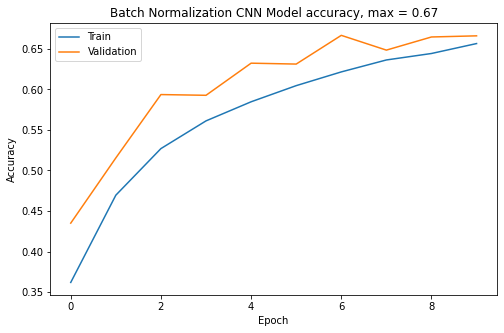

313/313 - 1s - loss: 0.9501 - accuracy: 0.6660 - 784ms/epoch - 3ms/step


In [ ]:
# Plot the evolution of (train/val) accuracy through epochs
model_CNN_dropnorm.compile(loss='categorical_crossentropy',
                           optimizer=opt,
                           metrics=['accuracy'])

history_dropnorm = model_CNN_dropnorm.fit(
    X_train, 
    encoded_target, 
    epochs=10, 
    batch_size=32, 
    validation_data=(X_test, encoded_target_test))

max_acc = max(history_dropnorm.history['val_accuracy'])
plt.figure(figsize=(8, 5))
plt.plot(history_dropnorm.history['accuracy'])
plt.plot(history_dropnorm.history['val_accuracy'])
plt.title(f'Batch Normalization CNN Model accuracy, max = {max_acc:.2f}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

test_loss, test_acc = model_CNN_dropnorm.evaluate(
    X_test, encoded_target_test, verbose=2)

Batch normalization accelerates the training process and allows the use of larger learning rates. We then observe faster convergence and better performance on the test set. It also can help the model to be less sensitive to the initialization of weights, which can help to avoid getting stuck in bad local optima.

#### Improvement
**18) Based on the CNNs you have considered so far in this lab, what would be the next improvement you would like to test to increase the validation accuracy of your model? Test it and comment.**

We would like to test **data augmentation** in order to try and improve the validation accuracy of our model : <br>
*How?* Applying mirror transformation\, to 'expand' the size of the original training set or adding white noise to the original picture and contorting the image by zooming and shrinking.

In [ ]:
data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
])

In [ ]:
optimized_model = Sequential([
    # Data preprocessing (data augmetation)
    data_augmentation, 
    # Conv1 
    Conv2D(filters=8, 
            kernel_size=(3, 3), 
            strides=1, 
            padding='valid', 
            activation='relu', 
            input_shape=X_train.shape[1:]),
    # Conv2 
    Conv2D(filters=8, 
            kernel_size=(3, 3), 
            strides=1, 
            padding='valid', 
            activation='relu'),
    # Pool1 
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # Batch1
    BatchNormalization(),
    # Dropout 1
    Dropout(rate = 0.25),
    # Conv3
    Conv2D(filters=32, 
           kernel_size=(3, 3), 
           strides=1, 
           padding='valid', 
           activation='relu'),
    # Conv4
    Conv2D(filters=32, 
           kernel_size=(3, 3), 
           strides=1, 
           padding='valid', 
           activation='relu'),
    # Pool2
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # Batch2
    BatchNormalization(),
    # Dropout2
    Dropout(rate = 0.25),
    # FC layers 
    Flatten(), # to turn input into a 1 dimensional array
    # Dense1 
    Dense(408, activation='relu'),
    # Batch 3
    BatchNormalization(),
    # Dropout3
    Dropout(rate = 0.25),
    # Output layer
    Dense(10, activation='softmax')
]) 


In [ ]:
# Plot the evolution of (train/val) accuracy through epochs

optimized_model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

history_optimized = optimized_model.fit(X_train, 
                                encoded_target, 
                                epochs=10, 
                                batch_size=32, 
                                validation_data=(X_test, encoded_target_test)
                                )

Epoch 1/10
1563/1563 [==============================] - 51s 31ms/step - loss: 2.1187 - accuracy: 0.2712 - val_loss: 2.2818 - val_accuracy: 0.2612
Epoch 2/10
1563/1563 [==============================] - 47s 30ms/step - loss: 1.9014 - accuracy: 0.3252 - val_loss: 1.9565 - val_accuracy: 0.3141
Epoch 3/10
1563/1563 [==============================] - 48s 30ms/step - loss: 1.8178 - accuracy: 0.3477 - val_loss: 1.8413 - val_accuracy: 0.3565
Epoch 4/10
1563/1563 [==============================] - 46s 29ms/step - loss: 1.7581 - accuracy: 0.3655 - val_loss: 1.8101 - val_accuracy: 0.3675
Epoch 5/10
1563/1563 [==============================] - 46s 29ms/step - loss: 1.7096 - accuracy: 0.3829 - val_loss: 1.7027 - val_accuracy: 0.4003
Epoch 6/10
1563/1563 [==============================] - 46s 29ms/step - loss: 1.6712 - accuracy: 0.3980 - val_loss: 1.8813 - val_accuracy: 0.3569
Epoch 7/10
1563/1563 [==============================] - 46s 29ms/step - loss: 1.6312 - accuracy: 0.4110 - val_loss: 2.2735 -

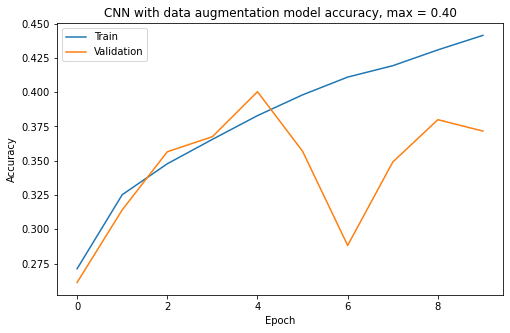

In [ ]:
max_acc = max(history_optimized.history['val_accuracy'])

plt.figure(figsize=(8, 5))
plt.plot(history_optimized.history['accuracy'])
plt.plot(history_optimized.history['val_accuracy'])
plt.title(f'CNN with data augmentation model accuracy, max = {max_acc:.2f}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# test_loss, test_acc = optimized_model.evaluate(
#    X_test, encoded_target_test, verbose=2)

Data augmentation has actually decreased the accuracy of our model. <br>

Our best model stays the one with Batch Normalization.



<a id='results'></a>

## 3.3 - Studying predictions

Assuming all went well during the previous tasks, you can now predict the category of a new image!  Here are a few examples of my predictions:

![predictions.png](predictions.png)

**19) Use `predict` on your trained model (the best you have created so far) to test its prediction on a few example images of the test set. Using `imshow` and `hbar` from `matplotlib.pyplot`, try to recreate the image above for few test images. Compute the accuracy of your model on the test set and comment.**

NB: You can save the model after training it (function `save` in keras), and then decide to load from saved file instead of building a new one (if available) on successive runs (via the function `load_model` in keras).**

In [ ]:
y_pred = model_CNN_dropnorm.predict(X_test)

313/313 [==============================] - 1s 2ms/step


The accuracy on the test set is 0.666


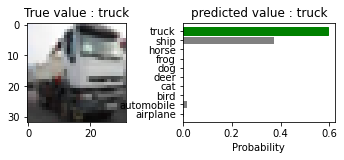

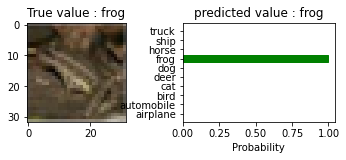

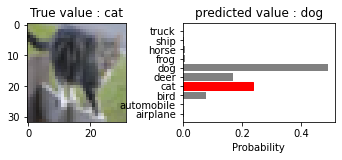

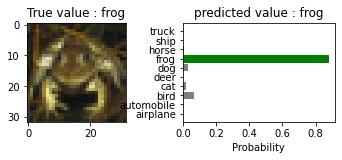

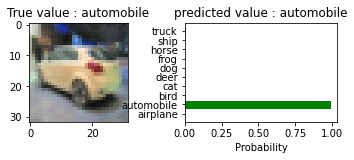

In [ ]:
# Compute the accuracy
print("The accuracy on the test set is", metrics.accuracy_score(y_test, y_pred.argmax(axis=1)) )

for j in range(5):
    j = np.random.randint(1000)
    index_pred = np.argmax(y_pred[j])
    index_true = y_test[j][0]
    fig = plt.figure()
    fig.add_subplot(221)
    my_image = X_test[j]
    plt.imshow(my_image)
    plt.title("True value : " + categories[index_true])
    fig.add_subplot(222)

    barlist = plt.barh(categories, y_pred[j], align='center', color='grey')
    plt.xlabel('Probability')
    if index_pred==index_true:
      barlist[y_test[j][0]].set_color('green')
    else:
      barlist[y_test[j][0]].set_color('red')
    plt.title("predicted value : " + categories[index_pred])
    plt.show()

A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents the predicted class j for each true class i.  Consider the following 10 predictions for a 2 category model predicting male or female.

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|        | predicted male | predicted female |
|--------|------|--------|
| true male   | 3    | 2      |
| true female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement. 

**20) Create the confusion matrix the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

313/313 [==============================] - 1s 2ms/step


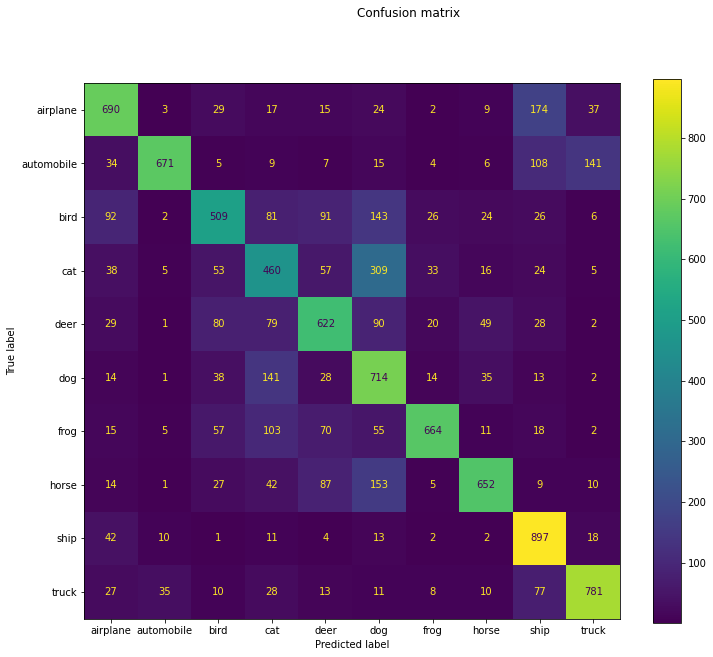

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model_CNN_dropnorm.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                            display_labels=categories)
fig, ax = plt.subplots(figsize=(12,10))
fig.suptitle('Confusion matrix')
cm_display.plot(ax=ax);

<a id='pretrained_cnn'></a>
# 4 - Pretrained Networks

Several pre-trained networks are directly accessible via keras.

**21) Build a classifier with a better accuracy on the test set than all CNN you have built before. One rule only: do not use CNN pretrained on CIFAR10.**

> **MobileNet** model pretrained on *imagenet* dataset with the top layer removed. Then we add a new top layer with a GlobalAveragePooling2D layer followed by two fully connected layers (1024,10) and freeze the weights of the layers of the pre-trained model so that they will not be updated during training, and then fit the model on train dataset. <br>
*Why chose Mobilenet ?* Because it is a very good tradeoff between accuracy and computationnal time : one of the fastest pre-trained network with good results and little parameters



In [ ]:
from tensorflow.keras.applications import MobileNet, VGG16
from keras.layers import GlobalAveragePooling2D

In [ ]:
base_model_MobileNet = MobileNet(input_shape=(32,32,3), 
                       include_top=False,
                       classes=10,
                       weights = "imagenet")

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
base_model_MobileNet.output_shape

(None, 1, 1, 1024)

In [ ]:
# Add a new top layer
model_mobilenet = Sequential([
    base_model_MobileNet,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(rate = 0.25),
    Dense(256, activation='relu'),
    Dense(100, activation='relu'),
    Dropout(rate = 0.25),
    Dense(10, activation='softmax')
    ])

In [ ]:
# Compile the model
model_mobilenet.compile(optimizer=opt, 
                        loss='categorical_crossentropy', 
                        metrics=['accuracy'])

# Fit the model and save the history
history_mobilenet = model_mobilenet.fit(
    X_train, encoded_target, 
    epochs=10, batch_size=32, 
    validation_data=(X_test, encoded_target_test),
    callbacks=EarlyStopping(
      monitor='val_accuracy', 
      min_delta=0, 
      patience=2, 
      mode='auto'
      ),
    verbose=2
    )

Epoch 1/10
1563/1563 - 22s - loss: 1.3632 - accuracy: 0.5284 - val_loss: 1.0840 - val_accuracy: 0.6330 - 22s/epoch - 14ms/step
Epoch 2/10
1563/1563 - 17s - loss: 0.9494 - accuracy: 0.6946 - val_loss: 0.9193 - val_accuracy: 0.6987 - 17s/epoch - 11ms/step
Epoch 3/10
1563/1563 - 18s - loss: 0.7982 - accuracy: 0.7421 - val_loss: 0.7128 - val_accuracy: 0.7607 - 18s/epoch - 11ms/step
Epoch 4/10
1563/1563 - 17s - loss: 0.6956 - accuracy: 0.7743 - val_loss: 0.6847 - val_accuracy: 0.7659 - 17s/epoch - 11ms/step
Epoch 5/10
1563/1563 - 17s - loss: 0.6236 - accuracy: 0.7975 - val_loss: 0.6688 - val_accuracy: 0.7782 - 17s/epoch - 11ms/step
Epoch 6/10
1563/1563 - 17s - loss: 0.5563 - accuracy: 0.8192 - val_loss: 0.6262 - val_accuracy: 0.7962 - 17s/epoch - 11ms/step
Epoch 7/10
1563/1563 - 18s - loss: 0.5103 - accuracy: 0.8329 - val_loss: 0.6907 - val_accuracy: 0.7657 - 18s/epoch - 11ms/step
Epoch 8/10
1563/1563 - 18s - loss: 0.4687 - accuracy: 0.8474 - val_loss: 0.7157 - val_accuracy: 0.7622 - 18s/ep

313/313 - 2s - loss: 0.7157 - accuracy: 0.7622 - 2s/epoch - 5ms/step


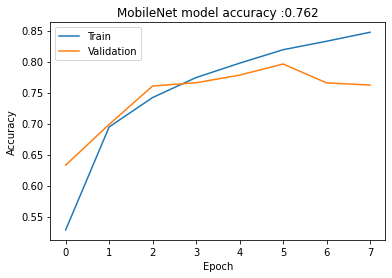

In [ ]:
# Plot the train and validation accuracy
model_mobilenet.evaluate(X_test, encoded_target_test, verbose=2)
last_epoch_acc = history_mobilenet.history['val_accuracy'][-1]

plt.plot(history_mobilenet.history['accuracy'])
plt.plot(history_mobilenet.history['val_accuracy'])
plt.title(f'MobileNet model accuracy :{last_epoch_acc:.3f}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show() ;

Here, we can see that the results are not very good for the MobileNet pre-trained model. It is not well suited for this dataset: Let us try something else<br>

> **VGG16** the top 2 pre-trained keras model right after Xception (that we could not use because the images are too small).It only take 1 more milisecond per inference step than MobileNet but has a better accuracy :  

In [ ]:
base_model_VGG = VGG16(input_shape=(32,32,3), 
                       include_top=False,
                       classes=10,
                       weights = "imagenet")

base_model_VGG.output_shape

58889256/58889256 [==============================] - 0s 0us/step


(None, 1, 1, 512)

In [ ]:
# Add a new top layer
model_VGG = Sequential([
    base_model_VGG,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate = 0.25),
    Dense(256, activation='relu'),
    Dense(100, activation='relu'),
    Dropout(rate = 0.25),
    Dense(10, activation='softmax')
    ])

In [ ]:
# Compile the model
model_VGG.compile(optimizer=opt, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy']
                  )

# Fit the model and save the history
history_VGG = model_VGG.fit(X_train, encoded_target, 
                            epochs=10, batch_size=32, 
                            validation_data=(X_test, encoded_target_test),
                            callbacks=EarlyStopping(
                                monitor='val_accuracy', 
                                min_delta=0, 
                                patience=2, 
                                mode='auto'),
                            verbose=2
                            )

Epoch 1/10
1563/1563 - 45s - loss: 1.4872 - accuracy: 0.4802 - val_loss: 1.3924 - val_accuracy: 0.5667 - 45s/epoch - 29ms/step
Epoch 2/10
1563/1563 - 42s - loss: 0.7630 - accuracy: 0.7547 - val_loss: 0.6760 - val_accuracy: 0.7805 - 42s/epoch - 27ms/step
Epoch 3/10
1563/1563 - 42s - loss: 0.5536 - accuracy: 0.8238 - val_loss: 0.7154 - val_accuracy: 0.7693 - 42s/epoch - 27ms/step
Epoch 4/10
1563/1563 - 42s - loss: 0.4268 - accuracy: 0.8630 - val_loss: 0.5635 - val_accuracy: 0.8143 - 42s/epoch - 27ms/step
Epoch 5/10
1563/1563 - 44s - loss: 0.3320 - accuracy: 0.8922 - val_loss: 0.7947 - val_accuracy: 0.7813 - 44s/epoch - 28ms/step
Epoch 6/10
1563/1563 - 42s - loss: 0.2671 - accuracy: 0.9135 - val_loss: 0.7996 - val_accuracy: 0.7732 - 42s/epoch - 27ms/step


313/313 - 3s - loss: 0.7996 - accuracy: 0.7732 - 3s/epoch - 8ms/step


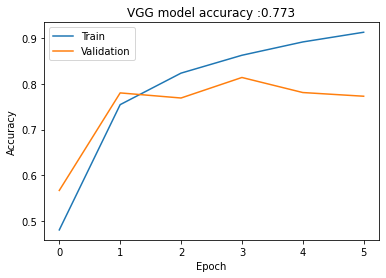

In [ ]:
# Plot the train and validation accuracy
model_VGG.evaluate(X_test, encoded_target_test, verbose=2)
last_epoch_acc = history_VGG.history['val_accuracy'][-1]

plt.plot(history_VGG.history['accuracy'])
plt.plot(history_VGG.history['val_accuracy'])
plt.title(f'VGG model accuracy :{last_epoch_acc:.3f}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left');

The results are more consistent and converge faster; it is better than the accuracy for MobileNet. We should stop at the 6th epoch.

In [ ]:
# This cell is here to assess the quality of the predictions of our model.

y_pred = model_VGG.predict(X_test)

print("The accuracy on the test set is", metrics.accuracy_score(y_test, y_pred.argmax(axis=1)))



313/313 [==============================] - 2s 7ms/step
The accuracy on the test set is 0.7732
